In [23]:
import pandas as pd
from matplotlib import pyplot as plt
from fbprophet import Prophet
from datetime import datetime
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from mlxtend.regressor import StackingRegressor
%matplotlib inline 

Load the dataset

In [24]:
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")
deposit_raw = pd.read_csv("deposit2019.csv")
loan_raw = pd.read_csv("loan2019.csv")

Rename columns for uniformity

In [25]:
deposit_raw= deposit_raw.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Extract account number,amount and timestamp

In [26]:
deposit= deposit_raw[['billrefnumber','amount','time']]

Convert to datetime type

In [27]:
deposit['time']=pd.to_datetime(deposit.time)


Retrieve train and test data

In [28]:
train = deposit[deposit.time.dt.month<3]
test = deposit[deposit.time.dt.month==3]

Group by each account

In [90]:
deposit_grouped = train.groupby([train.billrefnumber,train.time.dt.date]).agg({"amount": ['count','mean']})
deposit_grouped.columns = deposit_grouped.columns.droplevel(0)

deposit_grouped.head()

,,count,mean
billrefnumber,time,,
0074836,2019-02-14,2,300.0
01450001316,2019-01-30,1,300.0
01450002009,2019-01-24,1,200.0
01450003551,2019-01-24,1,500.0
01450005036,2019-01-17,1,1000.0


In [94]:
deposit_trans_grouped = train.groupby([train.time.dt.date]).count()

deposit_trans_grouped.drop(['billrefnumber','time'],inplace=True,axis=1)
deposit_trans_grouped.reset_index(inplace=True)
deposit_trans_grouped['time'] = pd.to_datetime(deposit_trans_grouped.time)
deposit_trans_grouped.head()

,time,amount
0,2019-01-01,539
1,2019-01-02,740
2,2019-01-03,385
3,2019-01-04,962
4,2019-01-05,287


In [95]:
df = deposit_grouped.reset_index(level=1)
df['time'] = pd.to_datetime(df.time)
df = df.merge(deposit_trans_grouped, on='time', how='left')
df.head()

,time,count,mean,amount
0,2019-02-14,2,300.0,808
1,2019-01-30,1,300.0,1748
2,2019-01-24,1,200.0,6082
3,2019-01-24,1,500.0,6082
4,2019-01-17,1,1000.0,1449


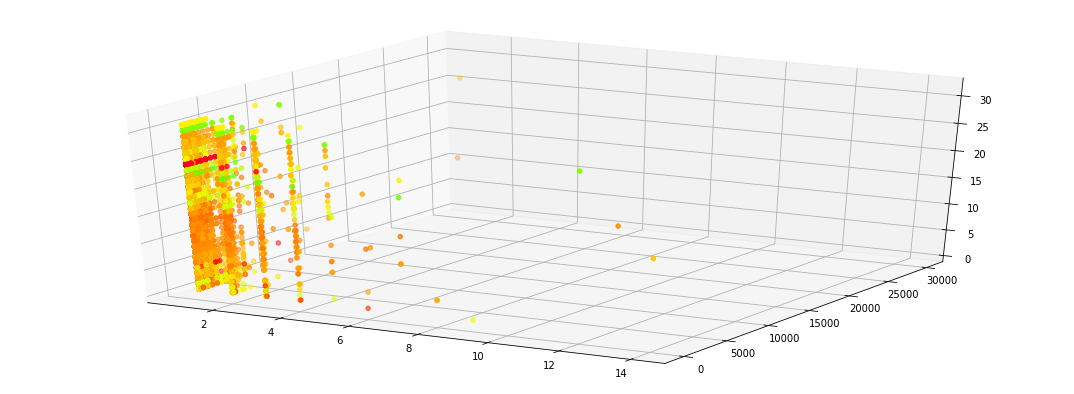

In [96]:
from mpl_toolkits import mplot3d
plt.rcParams['figure.figsize']=[19,7]
fig = plt.figure()
ax = plt.axes(projection="3d")
x= df['count']
y=df['mean']
z=df.time.dt.day
c=df.amount
ax.scatter3D(x, y,z,c=c, cmap='hsv')
#deposit_grouped.plot.ax.scatter3D(y='count',x='mean',z=deposit_grouped.index.get_level_values(1).hour)

In [32]:
df['count'].std()

0.31610380103388652

Is there any relationships between the multiple transactions and system being busy or "failure"?

In [67]:
x

<bound method DataFrame.count of                     time  count         mean
billrefnumber                               
0074836       2019-02-14      2   300.000000
01450001316   2019-01-30      1   300.000000
01450002009   2019-01-24      1   200.000000
01450003551   2019-01-24      1   500.000000
01450005036   2019-01-17      1  1000.000000
01450005366   2019-01-24      1   300.000000
01450005390   2019-01-13      1  1000.000000
01450006299   2019-01-24      1   100.000000
01450006315   2019-01-24      1    50.000000
01450006315   2019-02-01      1   100.000000
01450009111   2019-01-23      1   250.000000
01450009111   2019-01-31      1   150.000000
01450011745   2019-01-30      1   100.000000
01450012131   2019-01-09      1   500.000000
01450012131   2019-02-08      2   250.000000
01450012560   2019-02-19      1   300.000000
01450012560   2019-02-26      1   320.000000
01450014574   2019-02-22      1   500.000000
01450014764   2019-01-24      1    20.000000
01450015381   2019-02-